<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

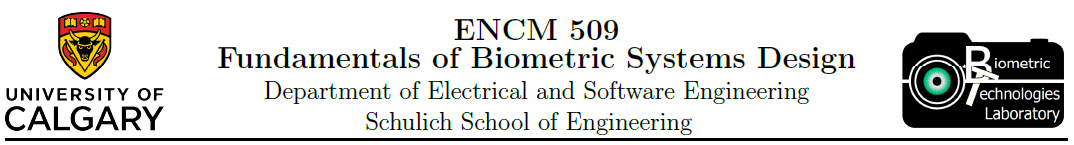

<center>
    <h1>ENCM509 Project</h1>
    <h2>Multi-Modal Authentication System</h2>
</center>

### Rumaisa Shoeb Talukder
### UCID: 30122975
### Group#: 23 (Solo)

## Introduction

This project implements a basic multi-modal authentication system using facial recognition (based on Local Binary Patterns and Euclidean distance) and speaker recognition (using Gaussian Mixture Models and MFCC features). By combining the outcomes from both modalities using a simple fusion strategy, I aim to explore the effectiveness of multi-modal verification in distinguishing between genuine users and impostors.

A multi-modal recognition system combines data from different sources or "modalities" to make more informed decisions. For example, while facial recognition analyzes visual features like shape, texture, or landmarks, speaker recognition focuses on vocal characteristics such as pitch, tone, and accent. When these two modalities are fused, they compensate for each other's weaknesses. For instance, if the face is partially obscured or poorly lit, the voice can still offer a reliable match—and vice versa.

This hybrid approach enhances recognition performance and makes the system more resistant to spoofing and environmental variations. In high-security applications such as access control, financial authentication, and forensics, multi-modal systems provide a higher level of assurance than their single-modal counterparts.

In [1]:
# Importing necessary packages
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from python_speech_features import mfcc
from skimage.feature import local_binary_pattern
from scipy.spatial.distance import euclidean
from sklearn.mixture import GaussianMixture
from scipy.io import wavfile
from scipy.stats import norm
import itertools

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, det_curve, DetCurveDisplay

print("Packages imported successfully.")   ## Debugging statement

# Training Parameters
# These values are altered according to the chosen number of testing and training samples
NUM_SUBJECTS = 2
NUM_PROBE_SAMPLES = 4
NUM_TRAINING_SAMPLES_PER_SUBJECT = 6
NUM_TESTING_SAMPLES_PER_SUBJECT = 4
NUMGCOMPONENTS = 20

Packages imported successfully.


### Speech Recognition: Helper Methods

Contains methods for loading and processing speech files, GMM score computation, plotting Probability Density Graph and Confusion Matrix

In [2]:
# Define directory path
DATA_DIR_SPEECH = "./speakers_audio_data"

# Process and load training and testing samples for genuine speakers
def genSpeakers(speaker):
    # loading files
    print("\nProcessing speaker: ", speaker)
    speaker_path = DATA_DIR_SPEECH + '/' + speaker + '/'
    print("speaker path:" + speaker_path)
    
    # Training samples:
    trainingsamples = []  # List to store training samples
    for i in range(1, NUM_TRAINING_SAMPLES_PER_SUBJECT + 1):
        trainingsamples.append(speaker_path + speaker + f"_0000{i}.wav")    
    
    print(f"{speaker} Training: {trainingsamples}\n")
    
    # Testing samples:
    testingsamples = []  # List to store testing samples
    for i in range(10, 10 + NUM_TESTING_SAMPLES_PER_SUBJECT):
        testingsamples.append(speaker_path + speaker + f"_000{i}.wav")
    
    print(f"{speaker} Testing: {testingsamples}\n")

    return trainingsamples, testingsamples


# Process and load samples for probe (impostor) speakers
def impSpeakers(speaker):
    # loading files
    print("\nProcessing speaker: ", speaker)
    speaker_path = DATA_DIR_SPEECH + '/' + speaker + '/'
    print("speaker path:" + speaker_path)
    
    probesamples = []  # List to store probe samples
    for i in range(NUM_PROBE_SAMPLES):
        probesamples.append(speaker_path + speaker + f"_00{i}.wav")    
    
    print(f"{speaker}: {probesamples}\n")

    return probesamples

# References:
# ENCM 509 Project-07-SpeakerRecongition v02
# ENCM 509 Lab3-SigVerif GMM.ipynb

# using nfft=1024 to avoid warning-
# WARNING:root:frame length (551) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

# Extract MFCC features from each .wav file
def extractMFCCFeatures(filePaths):
    features = []
    for filePath in filePaths: 
        samplerate, wave_data = wavfile.read(filePath) # Read the .wav file 
        mfcc_data = mfcc(wave_data, samplerate) # Compute the MFCC feautres 
        features.append(mfcc_data)
    return np.concatenate(features, axis=0) # Concatenate the features from all files into a single numpy array


# Calculate GMM score for a given set of filepaths using a specified GMM model
def calculateGMMScores(filePaths, gmmModel):
    scores = []   # list of GMM scores
    for filePath in filePaths: 
        samplerate, wave_data = wavfile.read(filePath) # Read the .wav file 
        mfcc_data = mfcc(wave_data, samplerate, nfft=1024) # Compute the MFCC feautres 
        score = gmmModel.score(mfcc_data) # compute the per-sample average log-likelihood of the given data.
        scores.append(score) # Concatenate the scores from all files into a single list
    return scores


# References:
# ENCM 509 Lab06-FaceRec2024.ipynb
# Plotting Probability Density Function (PDF) for Authentic and Impostor speeches
def plotProbabiltyDensityFunction(testScore, impostorScore, x, x_a, x_f, speakerGen, speakerImp):
    #x = np.arange(-58, -45, 0.01)
    
    # Calculate PDFs for authentic and forged data
    aProb = norm.pdf(x, loc=np.mean(testScore), scale=np.std(testScore))
    fProb = norm.pdf(x, loc=np.mean(impostorScore), scale=np.std(impostorScore))
    
    aScores = testScore
    fScores = impostorScore
    
    # Create the main plot
    plt.figure(figsize=(15, 5))
    
    # Plot the PDFs and the scores for both authentic and forged data
    plt.plot(x, aProb, 'g', label='Authentic Speech')
    plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic Scores')
    plt.plot(x, fProb, 'r', label='Impostor Speech')
    plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Impostor Scores')
    
    # Customize the plot
    plt.legend()
    plt.title(f'Score Distribution: {speakerGen} vs {speakerImp}', fontsize=18)
    plt.xlabel('Score')
    plt.ylabel('Probability Density')
    plt.show()
    
    # Separate Plots for Authentic and Forged data
    
    plt.figure(figsize=(10, 4))
    
    # Authentic set
    # x_a = np.arange(-50, -45, 0.01)
    aProb = norm.pdf(x_a, loc=np.mean(testScore), scale=np.std(testScore))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_a, aProb, 'g', label='Authentic Speech')
    plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic Scores')
    plt.legend()
    plt.title(f'{speakerGen} (Authentic)')
    plt.xlabel('Test Score')
    plt.ylabel('Probability Density')
    
    # Forged (Impostor) set
    # x_f = np.arange(-60, -50, 0.01)
    fProb = norm.pdf(x_f, loc=np.mean(impostorScore), scale=np.std(impostorScore))
    
    plt.subplot(1, 2, 2)
    plt.plot(x_f, fProb, 'r', label='Impostor Speech')
    plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Impostor Scores')
    plt.legend()
    plt.title(f'{speakerImp} (Impostor)')
    plt.xlabel('Probe Score')
    plt.ylabel('Probability Density')
    
    plt.tight_layout()
    plt.show()


# Classification Accuracy using Confusion Matrices
def createConfusionMatrix(testScore, probeScore, thresholdValue, subjectName):
    # Initialize confusion matrix values
    TP, FP, TN, FN = 0, 0, 0, 0
    
    # Calculate True Positives, False Negatives, True Negatives, and False Positives
    for score in testScore:
        if score < thresholdValue: # Check if below threshold value then increase the score for FN
            FN += 1
        else:
            TN += 1
    for score in probeScore:
        if score < thresholdValue: # Check if below threshold value then increase the score for TP
            TP += 1
        else:
            FP += 1
            
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print(f"\nConfusion Matrix for {subjectName}:")
    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))
    cm = np.array([[TP, FP], [FN, TN]])
    labels = np.array(["Probe/Impostor Speech", "Real Speech"]) # Set the labels for the matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap="plasma") # Create the matrix with passing the values for the TP,FP, FN, TN to the matrix
    plt.title(f'{subjectName} Confusion Matrix') # Set the title of the confusion matrix
    plt.show() # Show the confusion matrix on the screen

### Facial Recognition: Helper Methods

Contains methods for loading and processing image files, Euclidean Distance computation and visualization, and plotting Confusion Matrix

In [3]:
# References:
# Lab 06 - FaceRec

# Define directory path
DATA_DIR_FACIAL = "./ATT dataset"
total_images = 10

# Process and load training and testing samples for genuine subject faces
def genATTFaces(subject):
    # loading files
    print("\nProcessing subject: ", subject)
    subject_path = DATA_DIR_FACIAL + '/' + subject + '/'
    print("subject path:" + subject_path)

    samples = NUM_TRAINING_SAMPLES_PER_SUBJECT + NUM_TESTING_SAMPLES_PER_SUBJECT
    if samples > total_images:
        raise ValueError(f"Requested {samples} images, but only {total_images} are available.")

    # Load the first image to get dimensions
    img_sample = cv2.imread(subject_path + '1.pgm', cv2.IMREAD_GRAYSCALE)
    irow, icol = img_sample.shape

    # Allocate matrices for training and testing images
    training_images = np.zeros((irow * icol, NUM_TRAINING_SAMPLES_PER_SUBJECT))
    testing_images = np.zeros((irow * icol, NUM_TESTING_SAMPLES_PER_SUBJECT))

    # Variables for loading lbp features
    training_features = []
    testing_features = []
    
    # Load and display training images (1 to num_train)
    # === Training Images (2 rows, 3 cols) ===
    plt.figure(figsize=(12, 3))
    plt.suptitle("Training Images", fontsize=14)

    for i in range(1, NUM_TRAINING_SAMPLES_PER_SUBJECT + 1):
        img = cv2.imread(subject_path + f"{i}.pgm", cv2.IMREAD_GRAYSCALE)  # Read image in color and convert to grayscale
        img = np.float32(np.array(img)/255.0) # normalize to 0−1 value

        # LBP Feature Extraction
        lbp_train = extract_lbp_features(img, 12, 3)
        training_features.append(lbp_train)
        
        # plotting portion
        plt.subplot(1, NUM_TRAINING_SAMPLES_PER_SUBJECT, i)  # 1 rows, 6 columns (adjust based on the number of images)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
        # Reshape and store in matrix
        temp = np.reshape(img, (irow * icol, 1))  # Flatten the image
        training_images[:,i-1] = temp[:,0] 

    plt.show()
    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))
    print(f"Training data shape: {training_images.shape}\n")
    
    # Load and display testing images (num_train + 1 to num_train + num_test)
    # === Testing Images (2 rows, 2 cols) ===
    plt.figure(figsize=(8, 2.5)) # Separate figure for testing images
    plt.suptitle("Testing Images", fontsize=14)

    test_index = 0
    for i in range(NUM_TRAINING_SAMPLES_PER_SUBJECT + 1, NUM_TRAINING_SAMPLES_PER_SUBJECT + NUM_TESTING_SAMPLES_PER_SUBJECT + 1):
        img = cv2.imread(subject_path + f"{i}.pgm", cv2.IMREAD_GRAYSCALE)  # Read image in color and convert to grayscale
        img = np.float32(np.array(img)/255.0) # normalize to 0−1 value

        # LBP Feature Extraction
        lbp_test = extract_lbp_features(img, 12, 3)
        testing_features.append(lbp_test)

        # plotting portion
        plt.subplot(1, NUM_TESTING_SAMPLES_PER_SUBJECT, i-NUM_TRAINING_SAMPLES_PER_SUBJECT)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
                
        # Reshape and store in matrix
        temp = np.reshape(img, (irow * icol, 1))  # Flatten the image
        testing_images[:, test_index] = temp[:,0] 
        test_index += 1  # Increment test index

    plt.show()
    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))
    print(f"Training data shape: {testing_images.shape}\n")

    return np.array(training_images), np.array(testing_images), np.array(training_features), np.array(testing_features)


# Process and load probe samples for impostor (probe) subject images
def impATTfaces(subject):
    # loading files
    print("\nProcessing subject: ", subject)
    subject_path = DATA_DIR_FACIAL + '/' + subject + '/'
    print("subject path:" + subject_path)

    # Ensure the number of requested probe images does not exceed available images
    if NUM_PROBE_SAMPLES > total_images:
        raise ValueError(f"Requested {NUM_PROBE_SAMPLES} probe images, but only {total_images} are available.")

    # Load the first image to get dimensions
    img_sample = cv2.imread(subject_path + '1.pgm', cv2.IMREAD_GRAYSCALE)
    irow, icol = img_sample.shape

    selected_indices = sorted(random.sample(range(1, total_images + 1), NUM_PROBE_SAMPLES))
    
    probe_images = np.zeros((irow * icol, len(selected_indices)))  # initialize as a NumPy array
    probe_features = []
    
    plt.figure(figsize=(8, 2.5))
    plt.suptitle("Probe Images", fontsize=14)
    
    for index, i in enumerate(selected_indices):
        img = cv2.imread(subject_path + f"{i}.pgm", cv2.IMREAD_GRAYSCALE)  # Read image in color and convert to grayscale
        img = np.float32(np.array(img)/255.0) # normalize to 0−1 value

        # LBP Feature Extraction
        lbp = extract_lbp_features(img, 12, 3)
        probe_features.append(lbp)
        
        # plotting portion
        plt.subplot(1, NUM_PROBE_SAMPLES, index+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
        # Reshape and store in matrix
        temp = np.reshape(img, (irow * icol, 1))  # Flatten the image
        probe_images[:, index] = temp[:,0] 

    plt.show()
    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))
    print(f"Probe data shape: {probe_images.shape}\n")
    
    return np.array(probe_images), np.array(probe_features)


# Extract lbp features from image files
def extract_lbp_features(image, P=12, R=3):
    """
    Extracts LBP (Local Binary Pattern) features from a given grayscale image.
    P = Number of circularly symmetric neighbor points
    R = Radius of circle
    """

    # Check if image is 2D (grayscale), if not, raise an error
    if len(image.shape) != 2:
        raise ValueError("The input image must be a 2D array (grayscale).")
    image = np.uint8(image * 255)  
    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), density=True)
    return hist  # Returns a histogram of LBP features


# Calculate Euclidean distances
def calculate_euclidean(inputfeatures, trainfeatures):
    eDistance = []
    #labels = []
    
    for i, input_feat in enumerate(inputfeatures):
        for j, train_feat in enumerate(trainfeatures):
            dist = euclidean(input_feat, train_feat)
            eDistance.append(dist)
            #labels.append(f"T{i+1}-Tr{j+1}")
    
    eDistance = np.array(eDistance)

    return eDistance


# Plot Euclidean distance results
def plot_eucdistances(training_dist, testing_dist, probe_dist):
    # Combine all distances to find the global min and max
    all_distances = np.concatenate((training_dist, testing_dist, probe_dist))
    max_globaldist = np.max(all_distances)
    min_globaldist = np.min(all_distances)

    # Training vs. Train graph (6 * 6 = 36 labels)
    TrvsTr_labels = [f"TrS{i+1}vsTrS{j+1}" for i in range(NUM_TRAINING_SAMPLES_PER_SUBJECT) for j in range(NUM_TRAINING_SAMPLES_PER_SUBJECT)]
    
    # Training vs. Test graph (6 * 4 = 24 labels)
    TrvsTe_labels = [f"TrS{i+1}vsTeS{j+1}" for i in range(NUM_TRAINING_SAMPLES_PER_SUBJECT) for j in range(NUM_TESTING_SAMPLES_PER_SUBJECT)]
    
    # Training vs. Probe graph (6 * 4 = 24 labels)
    TrvsPr_labels = [f"TrS{i+1}vsPrS{j+1}" for i in range(NUM_TRAINING_SAMPLES_PER_SUBJECT) for j in range(NUM_PROBE_SAMPLES)]

    # List of distances to loop over, along with custom titles and colors for each
    distances = [
        ("Train-Training Pair", training_dist, "Training vs Train Set", 'green', TrvsTr_labels),
        ("Test-Training pair", testing_dist, "Training vs Test Set", 'blue', TrvsTe_labels),
        ("Probe-Training pair", probe_dist, "Training vs Probe Set", 'orange', TrvsPr_labels)
    ]
    
    # Loop over the distances for plotting and printing
    for x_title, dist, plot_title, colour, labels in distances:
        
        # Find the min and max for the current distance list
        max_dist = np.max(dist)
        min_dist = np.min(dist)
    
        # Print out the highest and lowest distances
        print(f"\n{plot_title} — Euclidean Distance Stats:")
        print(f"  ➤ Minimum Distance: {min_dist:.4f}")
        print(f"  ➤ Maximum Distance: {max_dist:.4f}")       
        print()
        
        #  distances plot
        plt.figure(figsize=(15, 6))
        plt.title(f'{plot_title}\nMin: {min_dist:.3f}, Max: {max_dist:.3f}', fontsize=18)
        plt.bar(np.arange(len(dist)), dist, tick_label=labels, color=colour)
        plt.xticks(rotation=90)
        plt.ylim([min_globaldist * 0.95, max_globaldist * 1.05])
        plt.xlabel(x_title)
        plt.ylabel('Euclidean Distance')
        plt.tight_layout()
        plt.show()


# Classification Accuracy using Confusion Matrices
def createConfusionMatrixEuclidean(impostorDistances, genuineDistances, threshold, subjectName):
    TP, FP, TN, FN = 0, 0, 0, 0
    
    # # Reshape distances if needed
    genuineDistances = genuineDistances.reshape(NUM_TESTING_SAMPLES_PER_SUBJECT, NUM_TRAINING_SAMPLES_PER_SUBJECT)
    impostorDistances = impostorDistances.reshape(NUM_PROBE_SAMPLES, NUM_TRAINING_SAMPLES_PER_SUBJECT)

    # Average distances for each test sample
    genuine_avg = np.mean(genuineDistances, axis=1)
    impostor_avg = np.mean(impostorDistances, axis=1)

    # Evaluate genuine samples
    for score in genuine_avg:
        if score < threshold:
            TP += 1  # Correctly accepted as genuine
        else:
            FP += 1  # Wrongly rejected as an impostor

    # Evaluate impostor samples
    for score in impostor_avg:
        if score < threshold:
            FN += 1  # Wrongly accepted as genuine
        else:
            TN += 1  # Correctly rejected as impostor

    # Metrics
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) != 0 else 0

    print(f"\nConfusion Matrix for {subjectName}:")
    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

    cm = np.array([[TP, FP], [FN, TN]])
    labels = np.array(["Genuine Images", "Impostor/Probe Images"])
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap="plasma")
    plt.title(f'{subjectName} Confusion Matrix')
    plt.show()

## Scenario 1:
### Speech Recognition: Speaker 0015 vs Speaker 0033 (Same Gender, Different Accents)

Speaker 0015 is a female with a southern accent
- Reading a book: A Lady's Life in the Rocky Mountains by Isabella Bird

Speaker 0033 is a female with a British accent
- Reading a book: Birds in the Calendar by F G Aflalo

In [4]:
# testing/training data files for Speaker_0015 -------------------------------------------------------------
speaker0015_training, speaker0015_testing = genSpeakers("Speaker_0015")
# data files for Speaker0033 - probe ----------------------------------------------------------------------
speaker0033_probe = impSpeakers("Speaker0033")

# References:
# ENCM 509 Project-07-SpeakerRecongition v02

# create a GMM with NUMGCOMPONENTS=20 components
speaker0015_GMM = GaussianMixture(n_components=NUMGCOMPONENTS) # Initializing the Gaussian mixture model object
speaker0015_MFCCFeatures = extractMFCCFeatures(speaker0015_training) # Function call to extract the MFCC features for the training data 
## print(f"Speaker 0015 MFCC features array: {speaker0015_MFCCFeatures[0]}\n") # To see the MFCC features array 
speaker0015_GMM.fit(speaker0015_MFCCFeatures) # Fitting the Gaussian Mixture Model to MFCC features

speaker0015trainscores = calculateGMMScores(speaker0015_training, speaker0015_GMM)
print(f"GMM Train scores: {speaker0015trainscores}\n")
# Same Subject speech scores
speaker0015TestScores = calculateGMMScores(speaker0015_testing, speaker0015_GMM) # Calculating the GMM scores for the testing dataset and passing the trained model 
print(f"GMM Scores for testing vs training data of Speaker 0015: {speaker0015TestScores}\n") # Printing the testing real speech scores

# Probe (impostor) Subject speech scores
speaker0015vs0033scores = calculateGMMScores(speaker0033_probe, speaker0015_GMM) # Calculating the GMM scores for the probe dataset and passing the trained model 
print(f"GMM Scores for Speaker 0015 vs probe Speaker 0033: {speaker0015vs0033scores}\n") # Printing the speech scores


Processing speaker:  Speaker_0015
speaker path:./speakers_audio_data/Speaker_0015/
Speaker_0015 Training: ['./speakers_audio_data/Speaker_0015/Speaker_0015_00001.wav', './speakers_audio_data/Speaker_0015/Speaker_0015_00002.wav', './speakers_audio_data/Speaker_0015/Speaker_0015_00003.wav', './speakers_audio_data/Speaker_0015/Speaker_0015_00004.wav', './speakers_audio_data/Speaker_0015/Speaker_0015_00005.wav', './speakers_audio_data/Speaker_0015/Speaker_0015_00006.wav']

Speaker_0015 Testing: ['./speakers_audio_data/Speaker_0015/Speaker_0015_00010.wav', './speakers_audio_data/Speaker_0015/Speaker_0015_00011.wav', './speakers_audio_data/Speaker_0015/Speaker_0015_00012.wav', './speakers_audio_data/Speaker_0015/Speaker_0015_00013.wav']


Processing speaker:  Speaker0033
speaker path:./speakers_audio_data/Speaker0033/
Speaker0033: ['./speakers_audio_data/Speaker0033/Speaker0033_000.wav', './speakers_audio_data/Speaker0033/Speaker0033_001.wav', './speakers_audio_data/Speaker0033/Speaker0033_

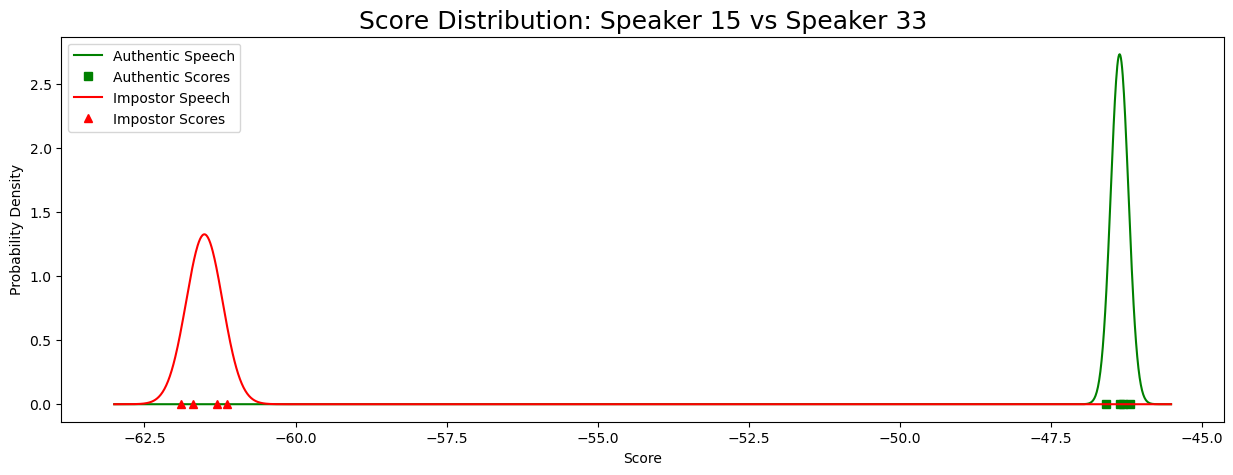

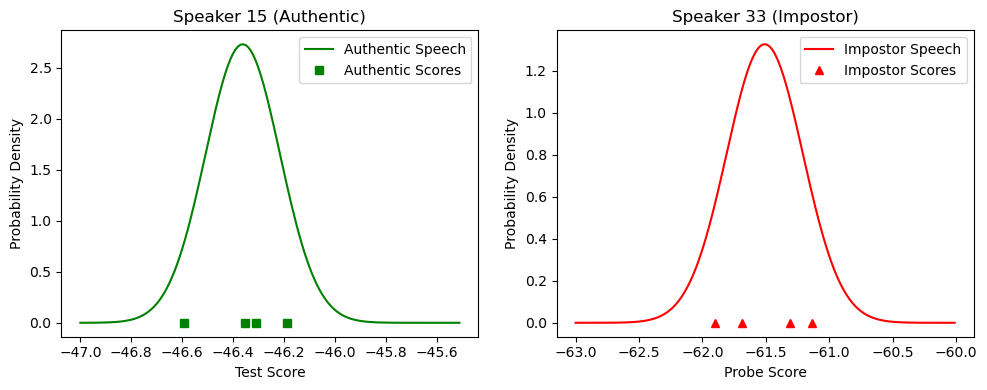

In [5]:
x = np.arange(-63, -45.5, 0.01)
x_a = np.arange(-47, -45.5, 0.01)
x_f = np.arange(-63, -60, 0.01)

plotProbabiltyDensityFunction(speaker0015TestScores, speaker0015vs0033scores, x, x_a, x_f, "Speaker 15", "Speaker 33")

### For Facial Recognition Subjects: Subject s35 vs Subject s10
#### Subject 35 (female) assigned for Speaker 0015
#### Subject 10 (female) assigned for Speaker 0033


Processing subject:  s35
subject path:./ATT dataset/s35/


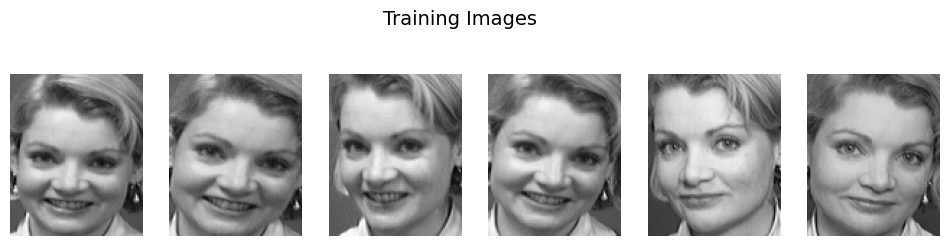

Size of each image: (112, 92) 10304
Training data shape: (10304, 6)



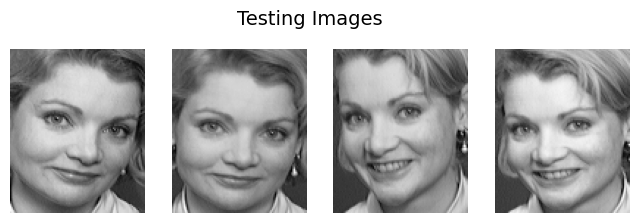

Size of each image: (112, 92) 10304
Training data shape: (10304, 4)


Processing subject:  s10
subject path:./ATT dataset/s10/


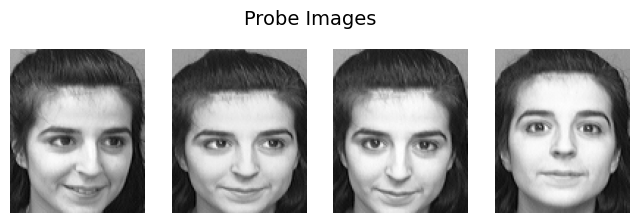

Size of each image: (112, 92) 10304
Probe data shape: (10304, 4)



In [6]:
## Subject 35 for Speaker 0015
s35_trainsamples, s35_testsamples, s35_trainfeatures, s35_testfeatures = genATTFaces('s35')

## Subject 10 for Speaker 0033
s10_probesamples, s10_probefeatures = impATTfaces('s10')


Training vs Train Set — Euclidean Distance Stats:
  ➤ Minimum Distance: 0.0000
  ➤ Maximum Distance: 0.0558



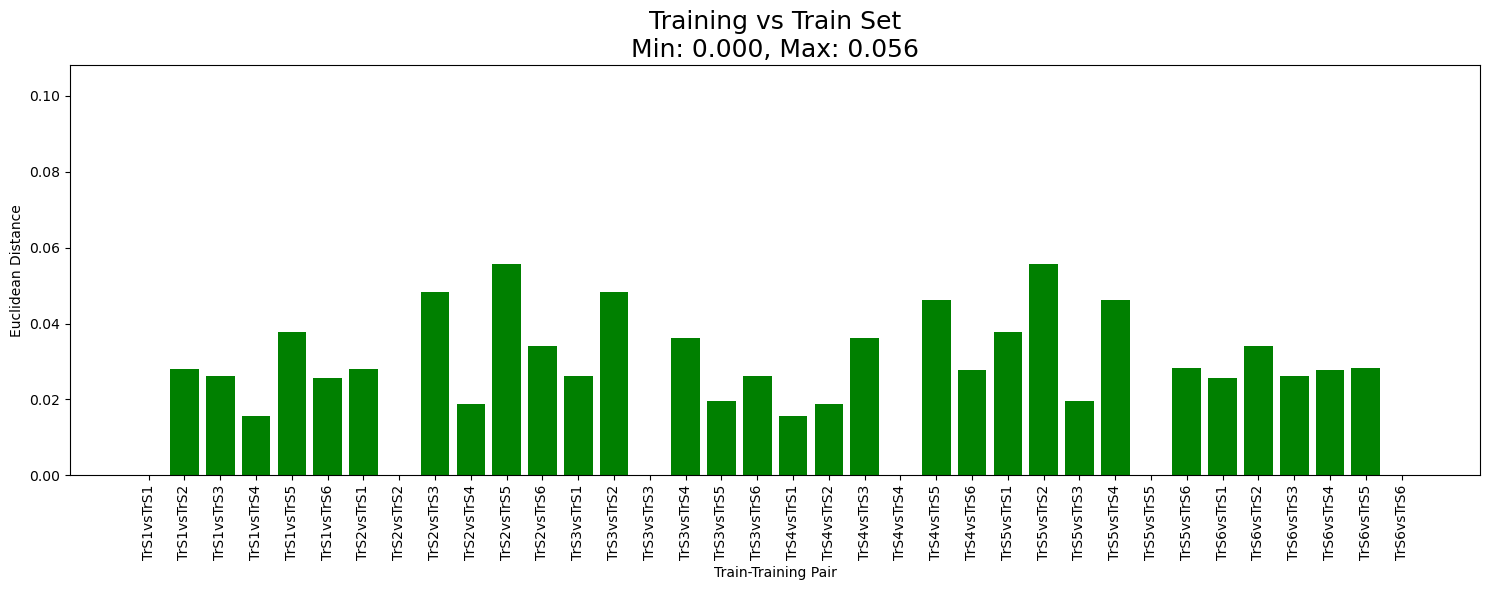


Training vs Test Set — Euclidean Distance Stats:
  ➤ Minimum Distance: 0.0086
  ➤ Maximum Distance: 0.0675



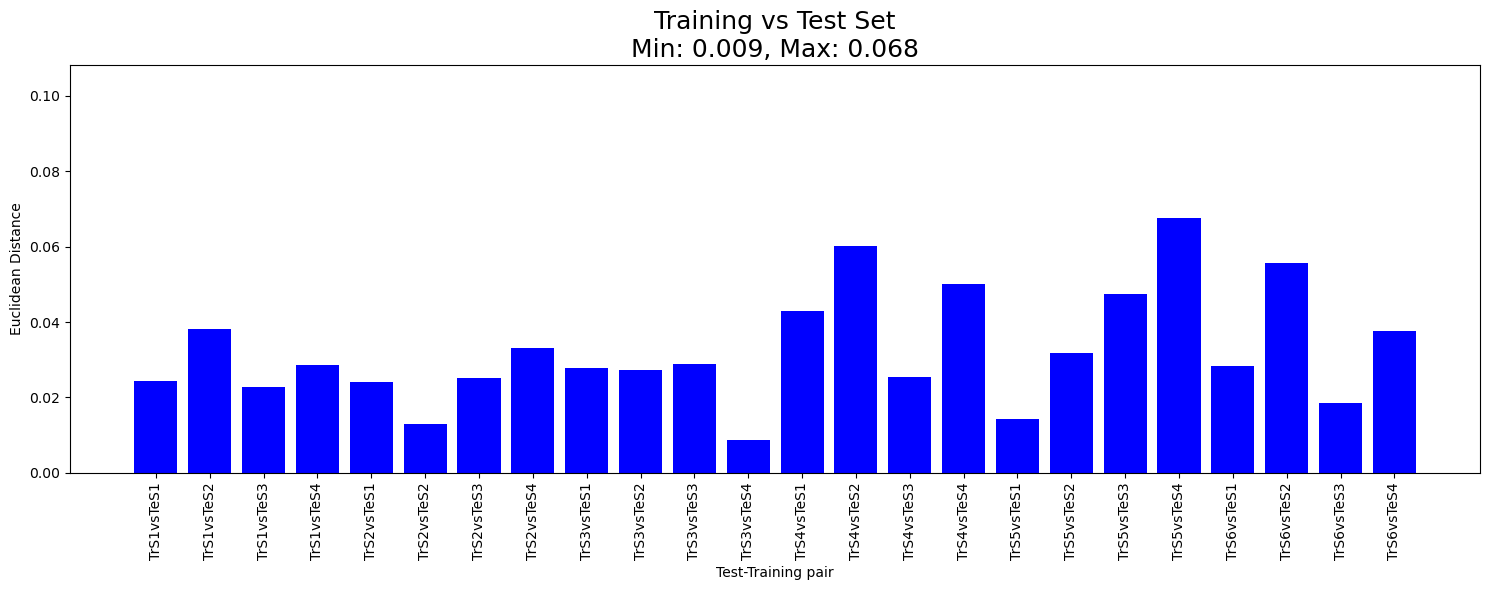


Training vs Probe Set — Euclidean Distance Stats:
  ➤ Minimum Distance: 0.0325
  ➤ Maximum Distance: 0.1029



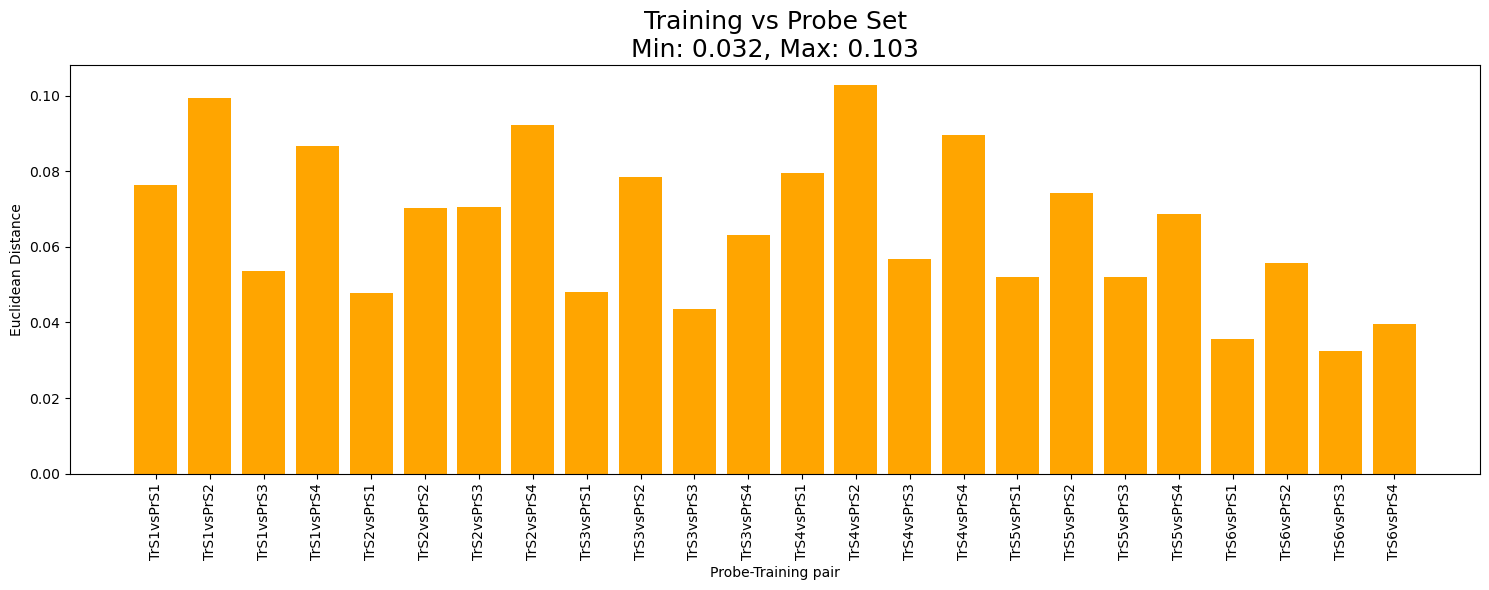

In [7]:
s35_trainDistance = calculate_euclidean(s35_trainfeatures, s35_trainfeatures)
s35_testDistance = calculate_euclidean(s35_testfeatures, s35_trainfeatures)
s10_probeDistance = calculate_euclidean(s10_probefeatures, s35_trainfeatures)

plot_eucdistances(s35_trainDistance, s35_testDistance, s10_probeDistance)

#### Note: The Euclidean Distance and the plot for Training vs Probe Set may be different for each run, as the images selected for the Probe Subject are randomly selected to test different images.

## Scenario 2:
### Speech Recognition: Speaker 0025 vs Speaker 0050 (Different Gender, Same Accent)

Speaker 0025 is an older male with an informative tone
- Reading a book: Chapter 5 from The ascent of Mount St.Elias (Alaska) by Filippo de Filippi

Speaker 0050 is a young female with a narrative (story-telling) tone
- Reading a book: Chapter 2 of the Stillwater Tragedy by Thomas Bailey Aldrich

In [8]:
# testing/training data files for Speaker_0025 -------------------------------------------------------------
speaker0025_training, speaker0025_testing = genSpeakers("Speaker_0025")
# data files for Speaker0050 - probe ----------------------------------------------------------------------
speaker0050_probe = impSpeakers("Speaker0050")

# References:
# ENCM 509 Project-07-SpeakerRecongition v02

# create a GMM with NUMGCOMPONENTS=20 components
speaker0025_GMM = GaussianMixture(n_components=NUMGCOMPONENTS) # Initializing the Gaussian mixture model object
speaker0025_MFCCFeatures = extractMFCCFeatures(speaker0025_training) # Function call to extract the MFCC features for the training data 
## print(f"Speaker 0025 MFCC features array: {speaker0025_MFCCFeatures[0]}\n") # To see the MFCC features array 
speaker0025_GMM.fit(speaker0025_MFCCFeatures) # Fitting the Gaussian Mixture Model to MFCC features

speaker0025trainscores = calculateGMMScores(speaker0025_training, speaker0025_GMM)
print(f"GMM Train scores: {speaker0025trainscores}")

# Same Subject speech scores
speaker0025TestScores = calculateGMMScores(speaker0025_testing, speaker0025_GMM) # Calculating the GMM scores for the testing dataset and passing the trained model 
print(f"GMM Scores for testing and training data of Speaker 0025: {speaker0025TestScores}\n") # Printing the testing real speech scores

# Probe (impostor) Subject speech scores
speaker0025vs0050scores = calculateGMMScores(speaker0050_probe, speaker0025_GMM) # Calculating the GMM scores for the probe dataset and passing the trained model 
print(f"GMM Scores for Speaker 0025 and probe Speaker 0050: {speaker0025vs0050scores}\n") # Printing the speech scores


Processing speaker:  Speaker_0025
speaker path:./speakers_audio_data/Speaker_0025/
Speaker_0025 Training: ['./speakers_audio_data/Speaker_0025/Speaker_0025_00001.wav', './speakers_audio_data/Speaker_0025/Speaker_0025_00002.wav', './speakers_audio_data/Speaker_0025/Speaker_0025_00003.wav', './speakers_audio_data/Speaker_0025/Speaker_0025_00004.wav', './speakers_audio_data/Speaker_0025/Speaker_0025_00005.wav', './speakers_audio_data/Speaker_0025/Speaker_0025_00006.wav']

Speaker_0025 Testing: ['./speakers_audio_data/Speaker_0025/Speaker_0025_00010.wav', './speakers_audio_data/Speaker_0025/Speaker_0025_00011.wav', './speakers_audio_data/Speaker_0025/Speaker_0025_00012.wav', './speakers_audio_data/Speaker_0025/Speaker_0025_00013.wav']


Processing speaker:  Speaker0050
speaker path:./speakers_audio_data/Speaker0050/
Speaker0050: ['./speakers_audio_data/Speaker0050/Speaker0050_000.wav', './speakers_audio_data/Speaker0050/Speaker0050_001.wav', './speakers_audio_data/Speaker0050/Speaker0050_

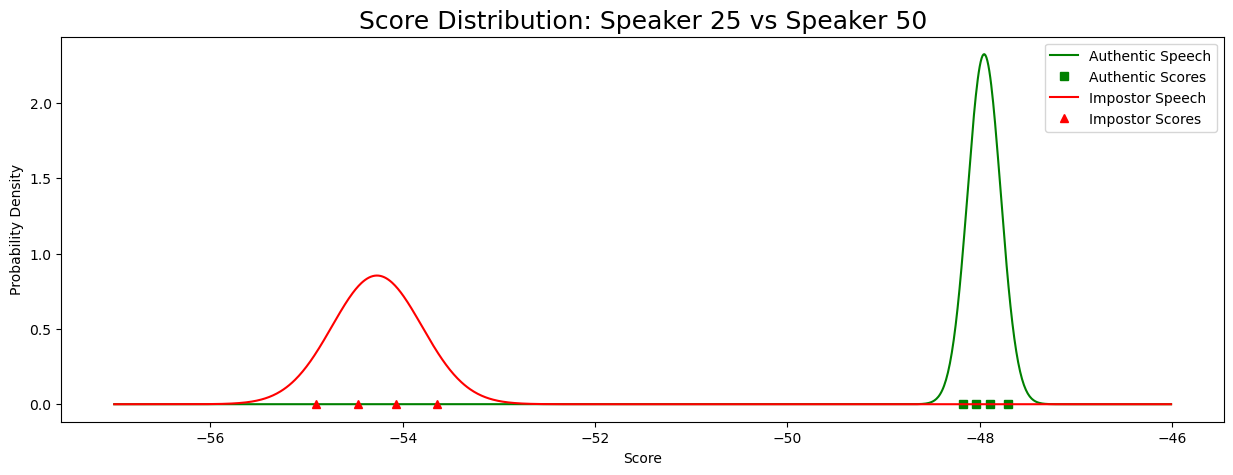

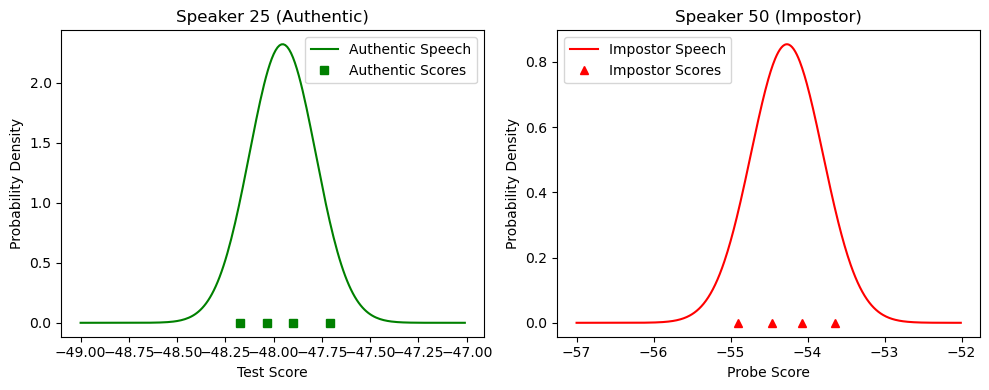

In [9]:
x = np.arange(-57, -46, 0.01)
x_a = np.arange(-49, -47, 0.01)
x_f = np.arange(-57, -52, 0.01)
plotProbabiltyDensityFunction(speaker0025TestScores, speaker0025vs0050scores, x, x_a, x_f, "Speaker 25", "Speaker 50")

### For Facial Recognition Subjects: Subject s34 vs Subject s8
#### Subject 34 (older male) assigned for Speaker 0025
#### Subject 8 (younger female) assigned for Speaker 0050


Processing subject:  s34
subject path:./ATT dataset/s34/


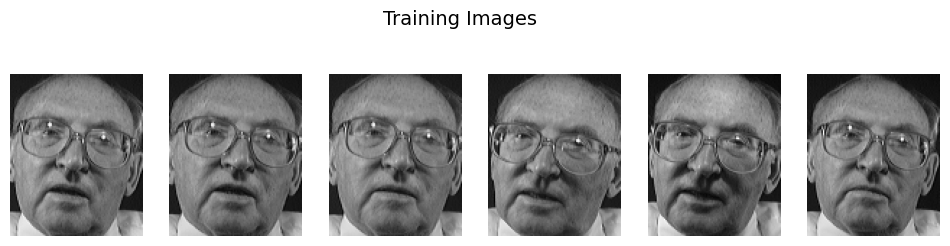

Size of each image: (112, 92) 10304
Training data shape: (10304, 6)



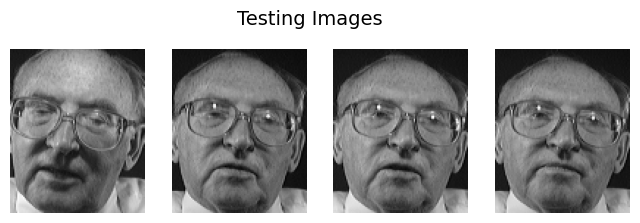

Size of each image: (112, 92) 10304
Training data shape: (10304, 4)


Processing subject:  s8
subject path:./ATT dataset/s8/


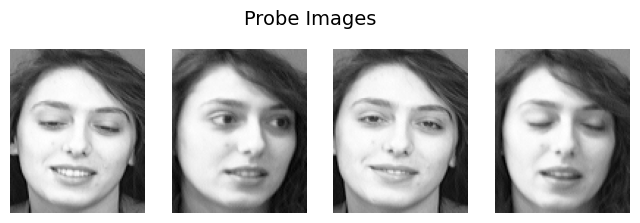

Size of each image: (112, 92) 10304
Probe data shape: (10304, 4)



In [10]:
## Subject 34 for Speaker 0025
s34_trainsamples, s34_testsamples, s34_trainfeatures, s34_testfeatures = genATTFaces('s34')

## Subject 8 for Speaker 0050
s8_probesamples, s8_probefeatures = impATTfaces('s8')


Training vs Train Set — Euclidean Distance Stats:
  ➤ Minimum Distance: 0.0000
  ➤ Maximum Distance: 0.0331



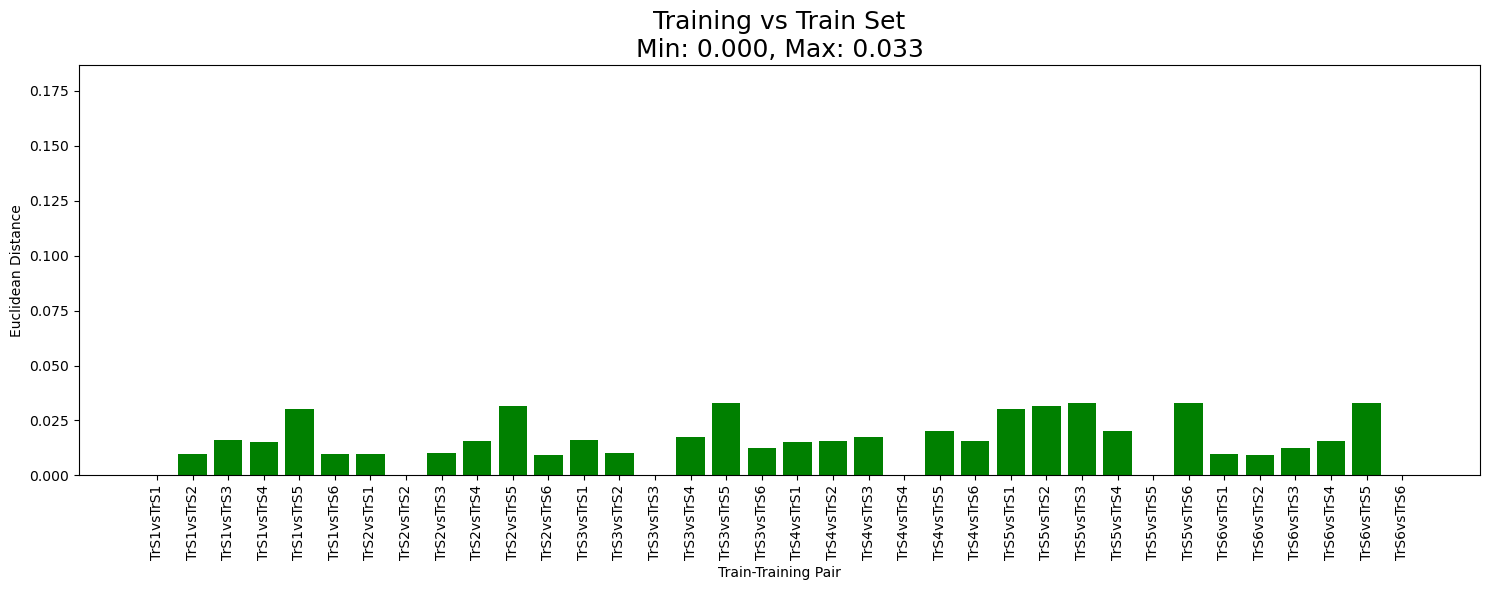


Training vs Test Set — Euclidean Distance Stats:
  ➤ Minimum Distance: 0.0065
  ➤ Maximum Distance: 0.0344



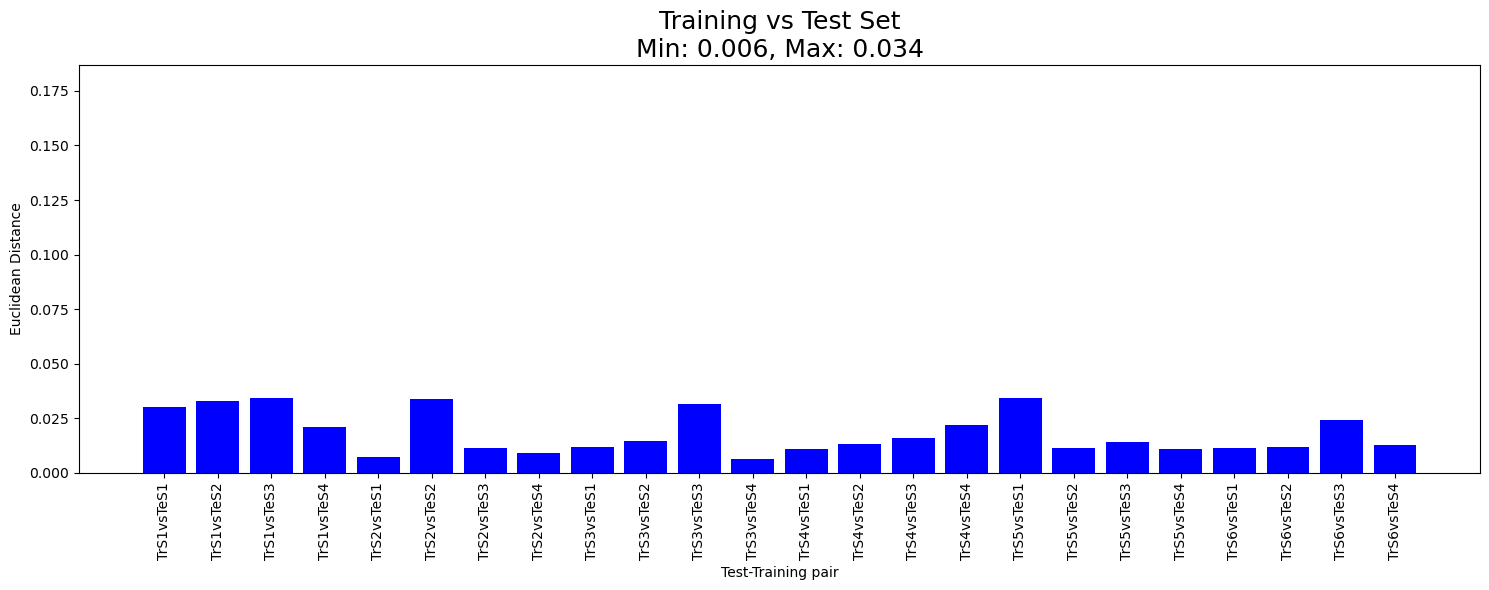


Training vs Probe Set — Euclidean Distance Stats:
  ➤ Minimum Distance: 0.1191
  ➤ Maximum Distance: 0.1779



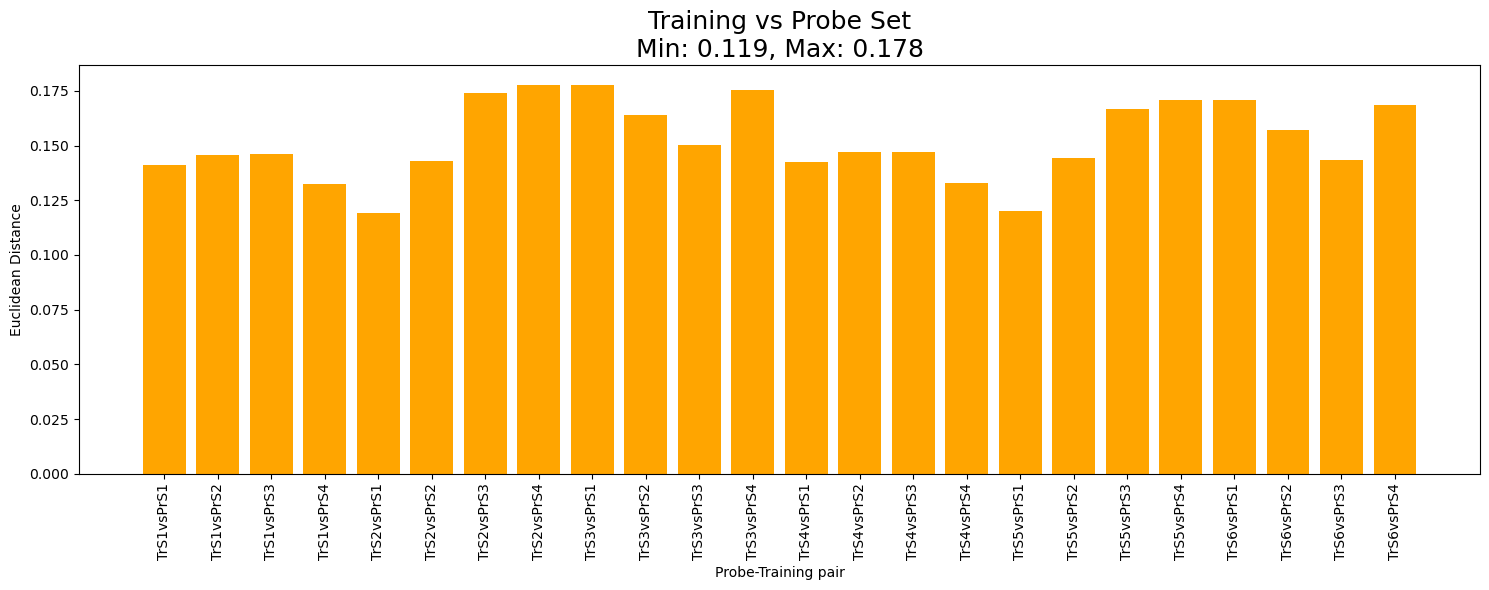

In [11]:
s34_trainDistance = calculate_euclidean(s34_trainfeatures, s34_trainfeatures)
s34_testDistance = calculate_euclidean(s34_testfeatures, s34_trainfeatures)
s8_probeDistance = calculate_euclidean(s8_probefeatures, s34_trainfeatures)

plot_eucdistances(s34_trainDistance, s34_testDistance, s8_probeDistance)

#### Note: The Euclidean Distance and the plot for Training vs Probe Set may be different for each run, as the images selected for the Probe Subject are randomly selected to test different images.

## Final Results - Fusion of Modalities

### Decision Logic:

The final decision is made by combining the outputs of both subsystems using the following rule-based approach:

#### If Speaker = Genuine AND Face = Genuine -> Final Result: Genuine

#### If Speaker = Impostor OR Face = Impostor -> Final Result: Impostor
- This includes scenarios where:
    - Speaker = Impostor AND Face = Impostor
    - Speaker = Genuine AND Face = Impostor
    - Speaker = Impostor AND Face = Genuine

#### To ensure accuracy, confusion matrices are used for independent Speech and Facial results respectively

In [12]:
# Define color codes
GREEN = "\033[32m"  # Green text
RED = "\033[31m"    # Red text
RESET = "\033[0m"   # Reset to default color


# Function to classify individual scenario Speech and Facial results
def classify_sample(subject, speaker, testscores, thresholdscores, testdistances, thresholddistances):

    # Calculating the threshold using training data
    # Assume `genuine_scores` is a list of GMM scores for the genuine training data
    mean_scoreGMM = np.mean(thresholdscores)
    std_scoreGMM = np.std(thresholdscores)
    # Set threshold to mean + 2 * standard deviation
    threshold_gmm = mean_scoreGMM - 10 * std_scoreGMM

    # print(f"meanscoreGMM: {mean_scoreGMM}")
    # print(f"std_scoreGMM: {std_scoreGMM}")
    # print(f"threshold_gmm: {threshold_gmm}")

    # Assume `genuine_distances` is a list of Euclidean distances for the genuine training data
    mean_distanceED = np.mean(thresholddistances)
    std_distanceED = np.std(thresholddistances)
    # Set threshold to mean + 2 * standard deviation
    threshold_lbp = mean_distanceED + 1.25 * std_distanceED

    # print(f"mean_distanceED: {mean_distanceED}")
    # print(f"std_distanceED: {std_distanceED}")
    # print(f"threshold_lbp: {threshold_lbp}")
    
    
    # 1. Speaker Recognition - GMM Score  -----------------------------------------------------
    gmm_score = np.mean(testscores)
    
    if gmm_score > threshold_gmm:
        speaker_class = "Genuine"
    else:
        speaker_class = "Impostor"
    print(f"Speaker {speaker}: {speaker_class}")

    # 2. Facial Recognition - Euclidean Distance  ----------------------------------------------
    euclidean_distance = np.mean(testdistances)    

    if euclidean_distance < threshold_lbp:
        facial_class = "Genuine"
    else:
        facial_class = "Impostor"
    print(f"Face Subject {subject}: {facial_class}")

    # 3. Fusion of Results (Majority Voting)  --------------------------------------------------
    if speaker_class == "Genuine" and facial_class == "Genuine":
        return "Genuine", threshold_gmm, threshold_lbp
    else:
        return "Impostor", threshold_gmm, threshold_lbp


# Function to print the Final Results for a given scenario with Colour Coded results
def print_classification_result(subject_label, result):
    if result == "Genuine":
        print(f"Final Conclusion for {subject_label}: {GREEN}{result} ✔️{RESET}\n")
    else:
        print(f"Final Conclusion for {subject_label}: {RED}{result} ❌{RESET}\n")

Subject A: Speaker 0015 / Subject s35
Subject B: Speaker 0033 / Subject s10

Speaker 0015: Genuine
Face Subject s35: Genuine
Final Conclusion for Subject A: Genuine ✔️

Speaker 0033: Impostor
Face Subject s10: Impostor
Final Conclusion for Subject B: Impostor ❌

Classification Accuracy using Confusion Matrices

Confusion Matrix for Speaker 15 vs 33:
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


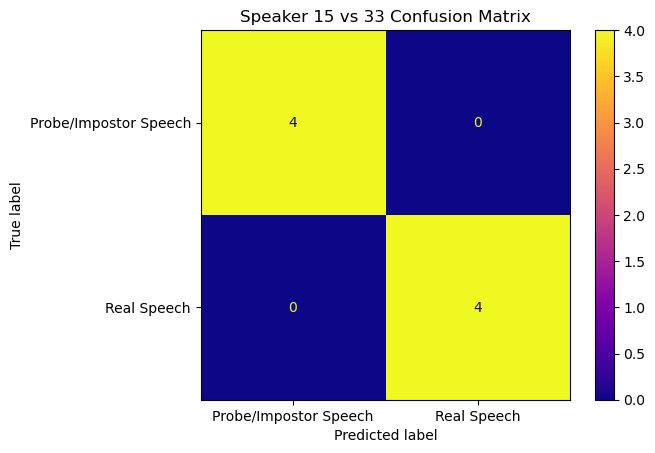


Confusion Matrix for Subject s35 vs s10:
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


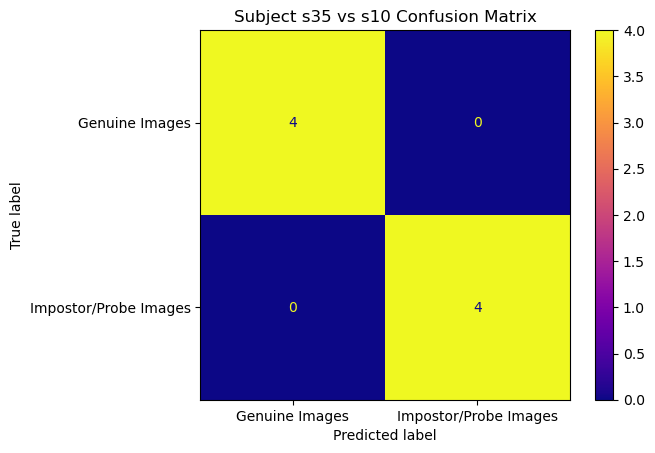

In [13]:
print("Subject A: Speaker 0015 / Subject s35\nSubject B: Speaker 0033 / Subject s10\n")

# Genuine - Speaker 0015 / Subject s35
result, threshold_gmm, threslbp = classify_sample('s35', '0015', speaker0015TestScores, speaker0015trainscores, s35_testDistance, s35_trainDistance)
print_classification_result("Subject A", result)

# Impostor - Speaker 0033 / Subject s10
result, threshold_gmm, threslbp = classify_sample('s10', '0033', speaker0015vs0033scores, speaker0015trainscores, s10_probeDistance, s35_trainDistance)
print_classification_result("Subject B", result)

# For classification accuracy
print("Classification Accuracy using Confusion Matrices")
createConfusionMatrix(speaker0015TestScores, speaker0015vs0033scores, threshold_gmm,'Speaker 15 vs 33') # Using the helper function to generate the confusion matrix
createConfusionMatrixEuclidean(s10_probeDistance, s35_testDistance, threslbp, 'Subject s35 vs s10')

Subject C: Speaker 0025 / Subject s34
Subject D: Speaker 0050 / Subject s8

Speaker 0025: Genuine
Face Subject s34: Genuine
Final Conclusion for Subject C: Genuine ✔️

Speaker 0050: Impostor
Face Subject s8: Impostor
Final Conclusion for Subject D: Impostor ❌

Classification Accuracy using Confusion Matrices

Confusion Matrix for Speaker 25 vs 50:
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


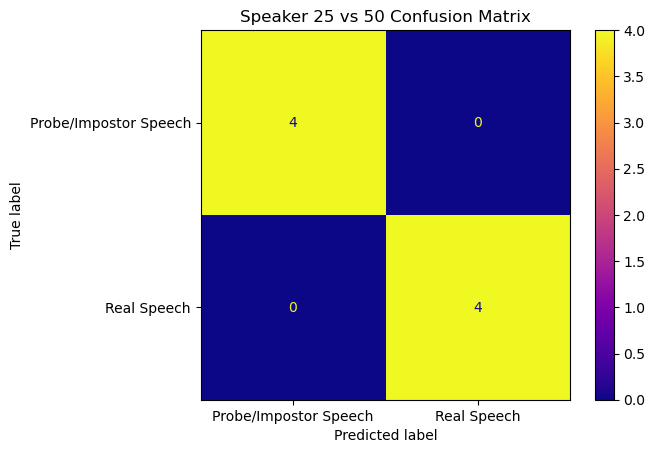


Confusion Matrix for Subject s34 vs s8:
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


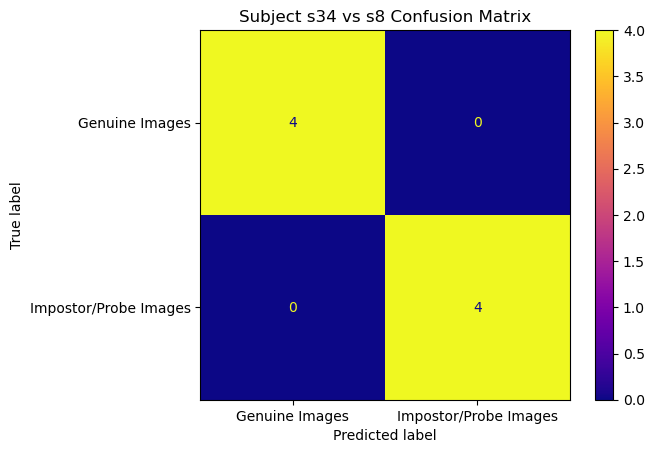

In [14]:
print("Subject C: Speaker 0025 / Subject s34\nSubject D: Speaker 0050 / Subject s8\n")

# Genuine - Speaker 0025 / Subject s34
result, threshold_gmm, thres_lbp = classify_sample('s34', '0025', speaker0025TestScores, speaker0025trainscores, s34_testDistance, s34_trainDistance)
print_classification_result("Subject C", result)

# Impostor - Speaker 0050 / Subject s8
result, threshold_gmm, threslbp = classify_sample('s8', '0050', speaker0025vs0050scores, speaker0025trainscores, s8_probeDistance, s34_trainDistance)
print_classification_result("Subject D", result)

# For classification accuracy
print("Classification Accuracy using Confusion Matrices")
createConfusionMatrix(speaker0025TestScores, speaker0025vs0050scores, threshold_gmm,'Speaker 25 vs 50') # Using the helper function to generate the confusion matrix
createConfusionMatrixEuclidean(s8_probeDistance, s34_testDistance, threslbp, 'Subject s34 vs s8')

## Conclusion

In summary, this project developed a multi-modal biometric authentication system combining speech and facial recognition using MFCC-GMM for speaker verification and LBP with Euclidean distance for face matching. Fusion of both modalities significantly improved accuracy, particularly in distinguishing genuine users from impostors.

Scenario comparisons showed that speech-based distinctions were more prominent between two female subjects than between a male and a female, likely due to accent variations. Conversely, face-based features were more similar between females, affecting Euclidean distances. These findings confirm that combining modalities enhances authentication by compensating for individual limitations in either speech or facial data.

A multi-modal authentication system can be deployed in a range of real-world applications, including biometric security for mobile devices, secure building access, ATMs, smart homes, e-learning exam proctoring, and sensitive data systems where strong and seamless identity verification is required.